# TinyGPT

**Author: Abraham R.**

The following notebook is an example of a really tiny GPT based model called TinyGPT.
You'll review the GPT architecture (transformer decoder) and implement the following tasks:

## TinyGPT Architecture

Tailored for the [NLP-II course](https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/CEIA-LLMIAG) as we deal with architectures and theory, this model consists of a **Mixture of Experts GPT**, equivalent to models like:
- DeepSeek
- Mistral

## Tasks

Using TinyGPT you need to implement the following modifications:


## Inference: Modify the generate function to:
- Greedy decoding (pick max probability token).
- Temperature sampling.
- top-k or top-p sampling.

### References
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)

## Architecture:
- Make TinyGPT a Mixture of Experts (MoE) of at least 2 experts.

## What to expect?

- You'll manage to understand a depth implementation of a GPT model.
- Implement a MoE Layer to create a state-of-the art GPT model.
- Explore decoding algorithms for text generation.


### NOTE

Tokenization is out of scope, we'll use a simple yet ineffective character-based tokenizer.


In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from dataclasses import dataclass, field
from typing import Optional, List, Type
import httpx

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from trainer import Trainer
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR

## Downloading Dataset

In [2]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = httpx.get(url)
text = response.text

text = text[:100_000]  # Using 100k characters for speedup
print(text)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



# Character-based encoding

In [3]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}
def encode(s): return [stoi[c] for c in s]
def decode(l): return ''.join([itos[i] for i in l])
data = torch.tensor(encode(text), dtype=torch.long)

# Train/test split
split = int(0.9 * len(data))
train_data = data[:split]
val_data = data[split:]

# Dataloaders

In [4]:
class CharDataset(Dataset):
    def __init__(self, data: torch.Tensor, block_size: int):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + self.block_size + 1]
        return x, y

# GPT Configuration

In [5]:
@dataclass
class MoEArgs():
    """
    MoE input arguments class.
    """
    num_experts : int = field(default=4)
    num_experts_per_token : int = field(default=2)

@dataclass
class GPTConfig:
    """
    Base class for GPT models.
    """
    block_size: int = 32
    batch_size: int = 8
    n_embd: int = 64
    n_head: int = 4
    n_layer: int = 2
    dropout: float = 0.1
    vocab_size: int = vocab_size
    bias: bool = True
    ff_class: Optional[Type[nn.Module]] = None
    moe : Optional[MoEArgs] = None

config = GPTConfig()
print(config.__dict__)

{'block_size': 32, 'batch_size': 8, 'n_embd': 64, 'n_head': 4, 'n_layer': 2, 'dropout': 0.1, 'vocab_size': 61, 'bias': True, 'ff_class': None, 'moe': None}


In [6]:
train_dataset = CharDataset(train_data, config.block_size)
val_dataset = CharDataset(val_data, config.block_size)

train_loader = DataLoader(train_dataset,
                        batch_size=config.batch_size,
                        shuffle=True,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 8, # if using mps set num_workers as 0.
                        )
val_loader = DataLoader(val_dataset,
                        batch_size=config.batch_size,
                        shuffle=False,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 8,
                        )

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [7]:
class AttentionHead(nn.Module):
    """
    Scaled Dot-Product Attention Head for Multi-Head Attention.
    """
    def __init__(self, args: GPTConfig) -> None:
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.head_dim = args.n_embd // args.n_head

        # Combined QKV projection
        self.key_query_value = nn.Linear(args.n_embd, 3 * self.head_dim, bias=args.bias)

        self.dropout = nn.Dropout(args.dropout)
        self.block_size = args.block_size
        self.register_buffer('tril', torch.tril(torch.ones(args.block_size, args.block_size)))

    def forward(self, x: torch.Tensor, kv_cache: Optional[torch.Tensor] = None, return_weights=False):
        B, T, C = x.shape
        key_query_value = self.key_query_value(x)  # (B, T, 3 * head_dim)
        k, q, v = torch.chunk(key_query_value, 3, dim=-1)  # (B, T, head_dim) each

        if kv_cache is not None:
            key_cache, value_cache = kv_cache.unbind(dim=0)  # (B, T', head_dim)
            k = torch.cat((key_cache, k), dim=1)
            v = torch.cat((value_cache, v), dim=1)

        # Scaled dot-product attention
        wei = q @ k.transpose(-2, -1) * (self.head_dim ** -0.5)  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        out = wei @ v  # (B, T, head_dim)

        if return_weights:
            return out, wei

        if kv_cache is not None:
            return out, torch.stack((k, v))

        return out, None

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self, args: GPTConfig):
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.n_heads = args.n_head
        self.head_dim = args.n_embd // args.n_head

        self.heads = nn.ModuleList([
            AttentionHead(args) for _ in range(self.n_heads)
        ])

        self.proj = nn.Linear(args.n_embd, args.n_embd, bias=args.bias)
        self.dropout = nn.Dropout(args.dropout)

    def forward(self, x, kv_cache=None, return_weights=False):
        all_outputs = []
        all_weights = []
        new_kv_cache = [] if kv_cache is not None else None

        for i, head in enumerate(self.heads):
            head_cache = kv_cache[i] if kv_cache is not None else None
            out, weights_or_kv = head(x, kv_cache=head_cache, return_weights=return_weights)
            all_outputs.append(out)
            if return_weights:
                all_weights.append(weights_or_kv)
            if kv_cache is not None:
                new_kv_cache.append(weights_or_kv)  # weights_or_kv is new kv_cache here

        concat = torch.cat(all_outputs, dim=-1)  # concat along embedding dim
        out = self.dropout(self.proj(concat))

        if return_weights:
            return out, torch.stack(all_weights)
        if kv_cache is not None:
            return out, new_kv_cache
        return out

In [9]:
class FeedForward(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention(config)

        ff_class = config.ff_class if config.ff_class is not None else FeedForward
        self.ff = ff_class(config)

    def forward(self, x, kv_cache=None, return_weights=False):
        attn_out = self.attn(self.ln1(x), kv_cache=kv_cache, return_weights=return_weights)
        if return_weights:
            attn_out, weights = attn_out
        else:
            weights = None

        if isinstance(attn_out, tuple):
            attn_out, updated_kv = attn_out
        else:
            updated_kv = None

        x = x + attn_out
        x = x + self.ff(self.ln2(x))
        return (x, updated_kv, weights) if return_weights else (x, updated_kv)

## TinyGPT Architecture

In [10]:
class TinyGPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.token_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Embedding(config.block_size, config.n_embd)
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.config = config

    def forward(self, idx, kv_cache=None, return_weights=False):
        B, T = idx.shape
        tok_emb = self.token_emb(idx)
        pos = torch.arange(T, device=idx.device)
        pos_emb = self.pos_emb(pos)[None, :, :]
        x = tok_emb + pos_emb

        new_kv_cache = [] if kv_cache is not None else None
        all_weights = [] if return_weights else None

        for i, block in enumerate(self.blocks):
            layer_kv = kv_cache[i] if kv_cache is not None else None
            if return_weights:
                x, updated_kv, weights = block(x, kv_cache=layer_kv, return_weights=True)
                all_weights.append(weights)  # weights shape: (n_heads, B, T, T)
            else:
                x, updated_kv = block(x, kv_cache=layer_kv)
            if kv_cache is not None:
                new_kv_cache.append(updated_kv)

        x = self.ln_f(x)
        logits = self.head(x)

        if return_weights:
            if kv_cache is not None:
                return logits, new_kv_cache, all_weights
            else:
                return logits, all_weights
        else:
            if kv_cache is not None:
                return logits, new_kv_cache
            return logits


## Generation function (inference)

In [11]:
@torch.no_grad()
def generate(prompt: str, max_new_tokens: int = 100, use_cache: bool = True):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        probs = F.softmax(logits[:, -1, :], dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

# Setup

In [12]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
m = TinyGPT(config).to(device)
model = torch.compile(m)

In [13]:
optimizer = AdamW(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 10

# Training

In [14]:
# Trainer instance
trainer = Trainer(
    model=model,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Training
for epoch in range(epochs):
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Epoch {epoch+1} training loss: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Epoch {epoch+1} validation loss: {val_loss:.4f}")

print("Training complete.")

  0%|          | 0/11246 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
W1118 22:26:55.940000 1358 torch/_inductor/utils.py:1436] [0/0] Not enough SMs to use max_autotune_gemm mode
/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:2509: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:2509: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_indu

Epoch 1 training loss: 2.0941


  0%|          | 0/1246 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val_loss 2.08041: 100%|██████████| 1246/1246 [00:10<00:00, 122.53it/s]


Epoch 1 validation loss: 2.0472


loss 2.15039: 100%|██████████| 11246/11246 [03:19<00:00, 56.46it/s]


Epoch 2 training loss: 2.1683


val_loss 2.08040: 100%|██████████| 1246/1246 [00:10<00:00, 124.18it/s]


Epoch 2 validation loss: 2.0472


loss 2.07340: 100%|██████████| 11246/11246 [03:17<00:00, 56.80it/s]


Epoch 3 training loss: 2.1204


val_loss 2.08040: 100%|██████████| 1246/1246 [00:10<00:00, 122.86it/s]


Epoch 3 validation loss: 2.0472


loss 2.08240: 100%|██████████| 11246/11246 [03:18<00:00, 56.71it/s]


Epoch 4 training loss: 2.0728


val_loss 2.08040: 100%|██████████| 1246/1246 [00:10<00:00, 122.91it/s]


Epoch 4 validation loss: 2.0472


loss 2.15234: 100%|██████████| 11246/11246 [03:19<00:00, 56.42it/s]


Epoch 5 training loss: 2.1720


val_loss 2.08040: 100%|██████████| 1246/1246 [00:09<00:00, 126.45it/s]


Epoch 5 validation loss: 2.0472


loss 2.07157: 100%|██████████| 11246/11246 [03:21<00:00, 55.69it/s]


Epoch 6 training loss: 2.0990


val_loss 2.08040: 100%|██████████| 1246/1246 [00:10<00:00, 120.37it/s]


Epoch 6 validation loss: 2.0472


loss 2.08520: 100%|██████████| 11246/11246 [03:21<00:00, 55.77it/s]


Epoch 7 training loss: 2.1273


val_loss 2.08040: 100%|██████████| 1246/1246 [00:10<00:00, 123.18it/s]


Epoch 7 validation loss: 2.0472


loss 2.10849: 100%|██████████| 11246/11246 [03:20<00:00, 56.09it/s]


Epoch 8 training loss: 2.0921


val_loss 2.08040: 100%|██████████| 1246/1246 [00:10<00:00, 122.71it/s]


Epoch 8 validation loss: 2.0472


loss 2.19382: 100%|██████████| 11246/11246 [03:20<00:00, 56.22it/s]


Epoch 9 training loss: 2.1169


val_loss 2.08040: 100%|██████████| 1246/1246 [00:10<00:00, 119.48it/s]


Epoch 9 validation loss: 2.0472


loss 2.08952: 100%|██████████| 11246/11246 [03:23<00:00, 55.18it/s]


Epoch 10 training loss: 2.1044


val_loss 2.08040: 100%|██████████| 1246/1246 [00:10<00:00, 116.63it/s]

Epoch 10 validation loss: 2.0472
Training complete.


### Quick test

In [15]:
generate("To be", max_new_tokens=100,use_cache=True)

"To bep elet in I'os, whip wold his we farand mold: bare, pop me I ancith your my foredes forsicl:\nWhorer "

# Task I

Using TinyGPT you need to implement the following modifications:


## Inference: Modify the generate function to:
- Greedy decoding (pick max probability token).
- Temperature sampling.
- top-k or top-p sampling.

### References
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)



In [16]:
# TODO Implement Greedy decoding, Temperature and top_k/top_p
@torch.no_grad()
def generateV2(
    prompt: str,
    model: nn.Module,
    max_new_tokens: int = 100,
    use_cache: bool = True,
    temperature: float = 1.0,
    top_k: Optional[int] = None,  # None = no aplicar
    top_p: Optional[float] = None,  # None = no aplicar
) -> Optional[str]:

    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        # Determinar entrada condicional
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        # Forward del modelo
        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)
        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits, kv_cache = out, None

        logits = logits[:, -1, :]

        # --- Greedy decoding (temperatura = 0 o muy baja) ---
        if temperature < 1e-8:
            next_token = torch.argmax(logits, dim=-1, keepdim=True)
        else:
            logits = logits / temperature
            probs = F.softmax(logits, dim=-1)

            # --- Top-k sampling ---
            if top_k is not None and top_k > 0:
                top_k_probs, top_k_indices = torch.topk(probs, min(top_k, probs.size(-1)))
                probs = torch.zeros_like(probs)
                probs.scatter_(1, top_k_indices, top_k_probs)
                probs = probs / probs.sum(dim=-1, keepdim=True)

            # --- Top-p sampling ---
            if top_p is not None and top_p < 1.0:
                sorted_probs, sorted_indices = torch.sort(probs, descending=True)
                cumsum_probs = torch.cumsum(sorted_probs, dim=-1)

                # Remover tokens donde la prob acumulada excede top_p
                sorted_indices_to_remove = cumsum_probs > top_p
                # Mantener al menos el primer token
                sorted_indices_to_remove[..., 0] = False

                # Crear máscara en el orden original
                indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
                probs[indices_to_remove] = 0.0
                probs = probs / probs.sum(dim=-1, keepdim=True)

            # Muestrear
            next_token = torch.multinomial(probs, num_samples=1)

        # concatenar al prompt
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

## Compare generate vs generateV2

Add your comments and findings

In [17]:
print(generate("To be", max_new_tokens=100,use_cache=True))

To beith'sen stisev, bem han wifarns, ear if there ratncconies--peapie, mushapton witg:
FENaver, you to w


In [18]:
print("=== GREEDY ===")
print(generateV2("To be", model, max_new_tokens=100, use_cache=True, temperature=0))

=== GREEDY ===
To be the the the the the the the the the the the the the the the the the the the the the the the the the


In [19]:
print("=== TEMP 0.7 ===")
print(generateV2("To be", model, max_new_tokens=100, temperature=0.7))

=== TEMP 0.7 ===
To bede bes have to lic,
The hare prous awe on at wionth is all he an of ronte the thor pours, thy and fe


In [20]:
print("=== TOP-K=10 ===")
print(generateV2("To be", model, max_new_tokens=100, temperature=1.0, top_k=10))

=== TOP-K=10 ===
To bey onsice ththe meneriten, ar herem bute as
I me hit scere wor, to andir momye nous ifirs
The thing, 


In [21]:
print("=== TOP-K=40 ===")
print(generateV2("To be", model, max_new_tokens=100, temperature=1.0, top_k=40))

=== TOP-K=40 ===
To bean the lite'd theve witer fouldg.

We CicCORIOLANIUS:
chetser miton:
S:
MENomeid plen and dor thy ch


In [22]:
print("=== TOP-P=0.9 ===")
print(generateV2("To be", model, max_new_tokens=100, temperature=1.0, top_p=0.9))

=== TOP-P=0.9 ===
To besea hantin
Thin our pars suent norsteshe cence, lim fo wicels matron sonse.

CORIA:
SIt norak, cand 


In [23]:
print("=== TEMP 0.7 + TOP-P 0.9 ===")
print(generateV2("To be", model, max_new_tokens=100, temperature=0.7, top_p=0.9))

=== TEMP 0.7 + TOP-P 0.9 ===
To bes ther shis delion the ser me hatthe at moond the and at as what the lour ben cathe of ferer of your


In [24]:
print("=== TEMP 1.5 + TOP-K=50 ===")
print(generateV2("To be", model, max_new_tokens=100, temperature=1.5, top_k=50))

=== TEMP 1.5 + TOP-K=50 ===
To beewa, bavookenn cuns hakefr cudcecpfethificu, is,nd nene noren a og,
Yojtn lin:
Thentlld demit wh gas


In [25]:
print("=== TEMP 0.5 + TOP-P 0.8 ===")
print(generateV2("To be", model, max_new_tokens=50, temperature=0.5, top_p=0.8))

=== TEMP 0.5 + TOP-P 0.8 ===
To be and the the he hat mare she sor ther the there of


## Task II
- Make TinyGPT a Mixture of Experts (MoE) of at least 2 experts.

In [26]:
class Expert(nn.Module):
    """Expert con arquitectura SwiGLU (state-of-the-art)"""
    def __init__(self, config: GPTConfig) -> None:
        super().__init__()
        hidden_dim = 4 * config.n_embd

        self.w1 = nn.Linear(config.n_embd, hidden_dim, bias=False)  # gate
        self.w2 = nn.Linear(config.n_embd, hidden_dim, bias=False)  # up
        self.w3 = nn.Linear(hidden_dim, config.n_embd, bias=False)  # down
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x) -> torch.Tensor:
        # SwiGLU: silu(w1(x)) ⊙ w2(x)
        return self.dropout(self.w3(F.silu(self.w1(x)) * self.w2(x)))


class Gate(nn.Module):
    """
    MoE gating network MLP.
    """

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.proj = nn.Linear(config.n_embd, config.moe.num_experts)

    def forward(self, x):
        return self.proj(x)

In [27]:
class MoELayer(nn.Module):
    """
    Mixture of experts FeedForward Layer
    """

    def __init__(self, experts : List[nn.Module], gate : nn.Module, moe_args : MoEArgs):
        super().__init__()
        self.experts = nn.ModuleList(experts)
        self.gate = gate
        self.args = moe_args

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, T, C)
        """
        B, T, C = x.size()
        num_experts = len(self.experts)
        k = self.args.num_experts_per_token

        # ---- 1. Compute gating logits and probabilities ----
        gate_logits = self.gate(x)                      # (B, T, E)
        gate_probs = F.softmax(gate_logits, dim=-1)     # (B, T, E)

        # ---- 2. Select top-k experts per token ----
        topk_weights, topk_idx = torch.topk(gate_probs, k, dim=-1)   # (B, T, k)

        # Normalizar los pesos top-k para que sumen 1
        topk_weights = topk_weights / topk_weights.sum(dim=-1, keepdim=True)  # (B, T, k)

        # ---- 3. Flatten para procesamiento por lotes ----
        x_flat = x.view(-1, C)  # (B*T, C)

        # Preparar salida
        output = torch.zeros_like(x_flat)  # (B*T, C)

        # ---- 4. Procesar cada expert ----
        for i in range(num_experts):
            # Encontrar qué tokens van al expert i
            # topk_idx: (B, T, k) -> queremos saber si i está en alguno de los k
            expert_mask = (topk_idx == i).any(dim=-1)  # (B, T)
            expert_mask_flat = expert_mask.view(-1)    # (B*T,)

            if expert_mask_flat.sum() == 0:
                continue  # No hay tokens para este expert

            # Obtener tokens que van al expert i
            expert_input = x_flat[expert_mask_flat]  # (N, C) donde N = num tokens
            expert_output = self.experts[i](expert_input)  # (N, C)

            # Obtener los pesos correspondientes
            # Para cada token en expert_input, necesitamos su peso
            # topk_idx (B, T, k) -> ver en qué posición de k está el expert i
            flat_topk_idx = topk_idx.view(B*T, k)  # (B*T, k)
            flat_topk_weights = topk_weights.view(B*T, k)  # (B*T, k)

            # Para los tokens seleccionados, obtener sus pesos
            selected_topk_idx = flat_topk_idx[expert_mask_flat]  # (N, k)
            selected_topk_weights = flat_topk_weights[expert_mask_flat]  # (N, k)

            # Encontrar en qué posición está el expert i para cada token
            expert_weights = torch.zeros(selected_topk_idx.size(0), device=x.device)
            for j in range(k):
                mask_j = (selected_topk_idx[:, j] == i)
                expert_weights[mask_j] = selected_topk_weights[mask_j, j]

            # Aplicar pesos y acumular
            weighted_output = expert_output * expert_weights.unsqueeze(-1)
            output[expert_mask_flat] += weighted_output

        # ---- 5. Reshape de vuelta ----
        output = output.view(B, T, C)
        return output

In [28]:
class MoEFFN(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.moe = MoELayer(
            experts=[Expert(config) for _ in range(config.moe.num_experts)],
            gate=Gate(config),
            moe_args=config.moe
        )

    def forward(self, x):
        return self.moe(x)

## Adding MoE to Config

In [29]:
config.ff_class = MoEFFN
config.moe = MoEArgs(num_experts=4, num_experts_per_token=2)

# Training TinyGPT-MoE


In [30]:
m_moe = TinyGPT(config).to(device)
model_moe = torch.compile(m_moe)

In [31]:
optimizer = AdamW(model_moe.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 10

In [32]:
# Trainer instance
trainer = Trainer(
    model=model_moe,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Training
for epoch in range(epochs):
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Epoch {epoch+1} training loss: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Epoch {epoch+1} validation loss: {val_loss:.4f}")

print("Training complete.")

  0%|          | 0/11246 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:2509: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:2509: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
loss 1.94186: 100%|██████████| 11246/11246 [08:29<00:00, 22.05it/s]


Epoch 1 training loss: 1.9372


  0%|          | 0/1246 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val_loss 1.93224: 100%|██████████| 1246/1246 [00:21<00:00, 57.17it/s]


Epoch 1 validation loss: 1.9189


  0%|          | 0/11246 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
loss 1.96007: 100%|██████████| 11246/11246 [08:36<00:00, 21.77it/s]


Epoch 2 training loss: 1.9062


val_loss 1.93223: 100%|██████████| 1246/1246 [00:21<00:00, 57.29it/s]


Epoch 2 validation loss: 1.9189


loss 1.89102: 100%|██████████| 11246/11246 [08:36<00:00, 21.79it/s]


Epoch 3 training loss: 1.9214


  0%|          | 0/1246 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val_loss 1.93223: 100%|██████████| 1246/1246 [00:21<00:00, 58.37it/s]


Epoch 3 validation loss: 1.9189


loss 1.95684: 100%|██████████| 11246/11246 [08:34<00:00, 21.87it/s]


Epoch 4 training loss: 1.9280


val_loss 1.93223: 100%|██████████| 1246/1246 [00:21<00:00, 57.46it/s]


Epoch 4 validation loss: 1.9189


loss 1.92512: 100%|██████████| 11246/11246 [08:33<00:00, 21.91it/s]


Epoch 5 training loss: 1.9954


val_loss 1.93223: 100%|██████████| 1246/1246 [00:21<00:00, 57.09it/s]


Epoch 5 validation loss: 1.9189


loss 1.92950: 100%|██████████| 11246/11246 [08:35<00:00, 21.83it/s]


Epoch 6 training loss: 1.9540


val_loss 1.93223: 100%|██████████| 1246/1246 [00:21<00:00, 58.60it/s]


Epoch 6 validation loss: 1.9189


loss 1.91458: 100%|██████████| 11246/11246 [08:27<00:00, 22.15it/s]


Epoch 7 training loss: 1.9372


val_loss 1.93223: 100%|██████████| 1246/1246 [00:20<00:00, 59.95it/s]


Epoch 7 validation loss: 1.9189


loss 2.06282: 100%|██████████| 11246/11246 [08:28<00:00, 22.10it/s]


Epoch 8 training loss: 1.9435


val_loss 1.93223: 100%|██████████| 1246/1246 [00:21<00:00, 57.00it/s]


Epoch 8 validation loss: 1.9189


loss 1.95701: 100%|██████████| 11246/11246 [08:29<00:00, 22.05it/s]


Epoch 9 training loss: 1.9998


val_loss 1.93223: 100%|██████████| 1246/1246 [00:21<00:00, 57.90it/s]


Epoch 9 validation loss: 1.9189


loss 1.93624: 100%|██████████| 11246/11246 [08:28<00:00, 22.11it/s]


Epoch 10 training loss: 1.9629


val_loss 1.93223: 100%|██████████| 1246/1246 [00:21<00:00, 57.07it/s]

Epoch 10 validation loss: 1.9189
Training complete.


In [33]:
print("=== GREEDY ===")
print(generateV2("To be", model_moe, max_new_tokens=100, use_cache=True, temperature=0))

=== GREEDY ===
To be the the the the the the the the the the the the the the the the the the the the the the the the the


In [34]:
print("=== TEMP 0.7 ===")
print(generateV2("To be", model_moe, max_new_tokens=100, temperature=0.7))

=== TEMP 0.7 ===
To beave hater his conser
Thas of vis they benche fortion, are his am worces!

COMINIA:
I thavessere ouse


In [35]:
print("=== TOP-K=10 ===")
print(generateV2("To be", model_moe, max_new_tokens=100, temperature=1.0, top_k=10))

=== TOP-K=10 ===
To bestrarius,
Thin but me the hat strusies
Wh cathat they allore al will we an on ar to ally
As thath wa


In [36]:
print("=== TOP-K=40 ===")
print(generateV2("To be", model_moe, max_new_tokens=100, temperature=1.0, top_k=40))

=== TOP-K=40 ===
To beery riplesst
Tupre it Citizenen:
I itie agline d'eed harvenc but manity sponiertion.
They Ciseen:
Th


In [37]:
print("=== TOP-P=0.9 ===")
print(generateV2("To be", model_moe, max_new_tokens=100, temperature=1.0, top_p=0.9))

=== TOP-P=0.9 ===
To be ham be harmsin poth him
peeeall the the a you he their all of thar por the thars
To if fich there h


In [38]:
print("=== TEMP 0.7 + TOP-P 0.9 ===")
print(generateV2("To be", model_moe, max_new_tokens=100, temperature=0.7, top_p=0.9))

=== TEMP 0.7 + TOP-P 0.9 ===
To beee the pears
Wet she not wor he that in the hat here wor of are onts,
No struck for com the beare me


In [39]:
print("=== TEMP 1.5 + TOP-K=50 ===")
print(generateV2("To be", model_moe, max_new_tokens=100, temperature=1.5, top_k=50))

=== TEMP 1.5 + TOP-K=50 ===
To be'see noty.

SICIUS:
Yourbll. I I lonks lontec.

CYouzengo'l!

COMINIOLANUS:d- wiby. dompat im are: b


In [40]:
print("=== TEMP 0.5 + TOP-P 0.8 ===")
print(generateV2("To be", model_moe, max_new_tokens=50, temperature=0.5, top_p=0.8))

=== TEMP 0.5 + TOP-P 0.8 ===
To beand the heart the his mand and of wer the heare he


## Visualizing Attention

As we know, a GPT has the task to complete text, let's see the attention maps generated by a pretrained model

In [41]:
@torch.no_grad()
def visualize_attention(model, prompt, max_len=10):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)

    # Run forward with return_weights=True
    logits, all_weights = model(idx, return_weights=True)

    # all_weights is a list of length n_layers
    # each element: shape (n_heads, batch_size, seq_len, seq_len)
    # We'll visualize the first batch element only

    n_layers = len(all_weights)
    n_heads = all_weights[0].shape[0]
    seq_len = all_weights[0].shape[-1]

    for layer_i in range(n_layers):
        fig, axes = plt.subplots(1, n_heads, figsize=(5 * n_heads, 5))
        if n_heads == 1:
            axes = [axes]
        for head_i in range(n_heads):
            attn = all_weights[layer_i][head_i, 0].cpu()  # shape (seq_len, seq_len)
            im = axes[head_i].imshow(attn, cmap='viridis')
            axes[head_i].set_title(f'Layer {layer_i + 1} Head {head_i + 1}')
            axes[head_i].set_xlabel('Key Position')
            axes[head_i].set_ylabel('Query Position')
            axes[head_i].set_xticks(range(seq_len))
            axes[head_i].set_yticks(range(seq_len))
            fig.colorbar(im, ax=axes[head_i])
        plt.tight_layout()
        plt.show()


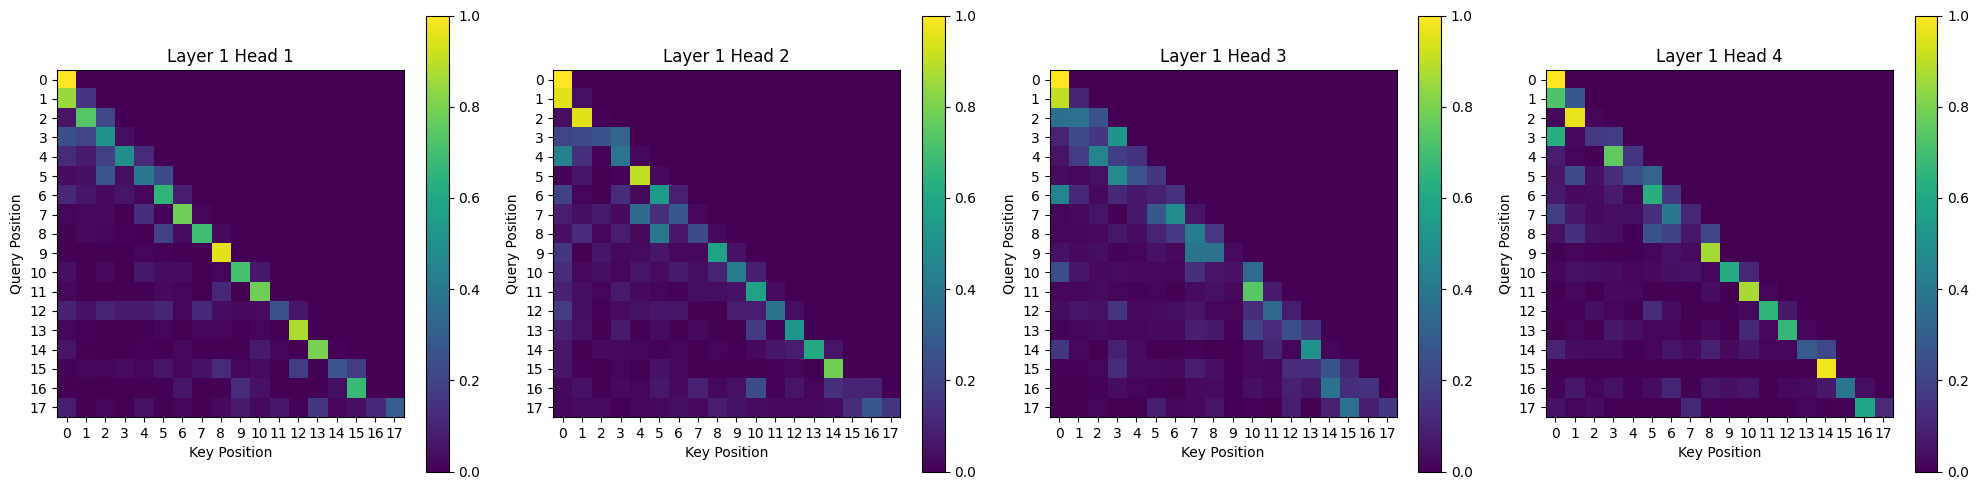

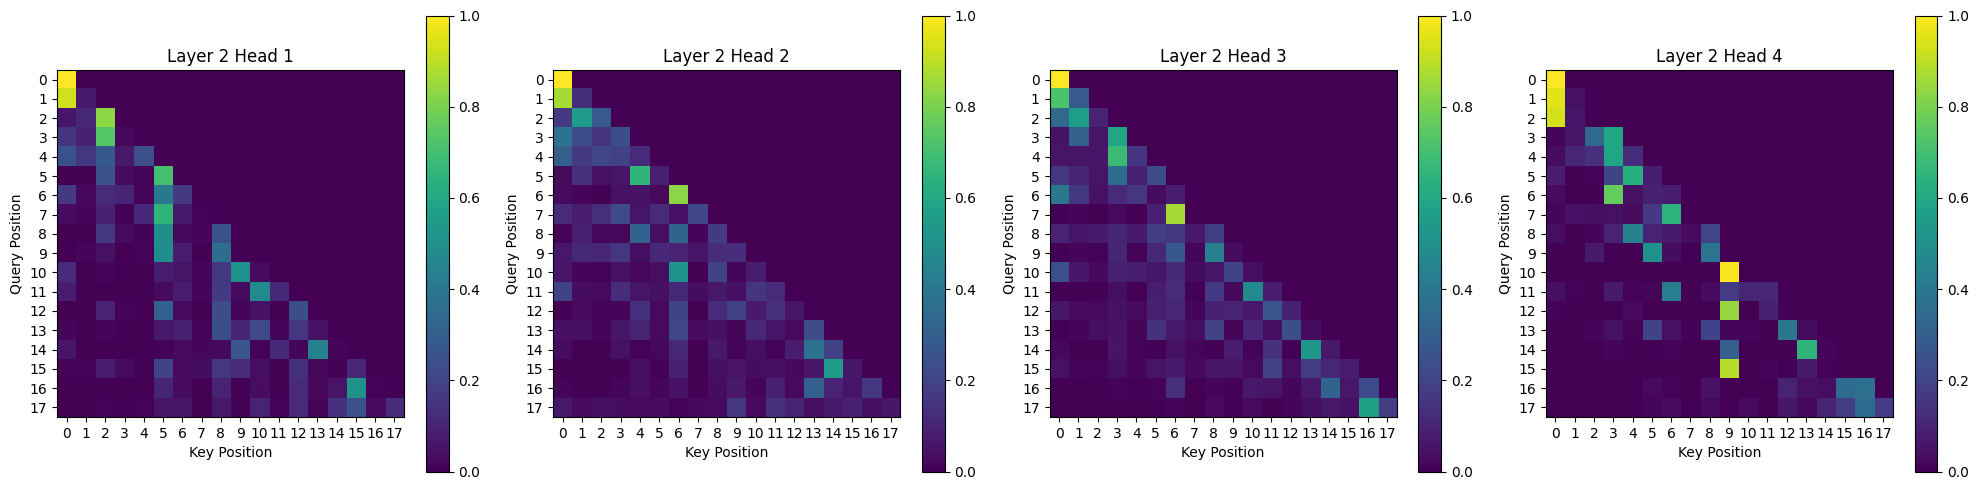

In [42]:
prompt = "To be or not to be"
visualize_attention(model, prompt)

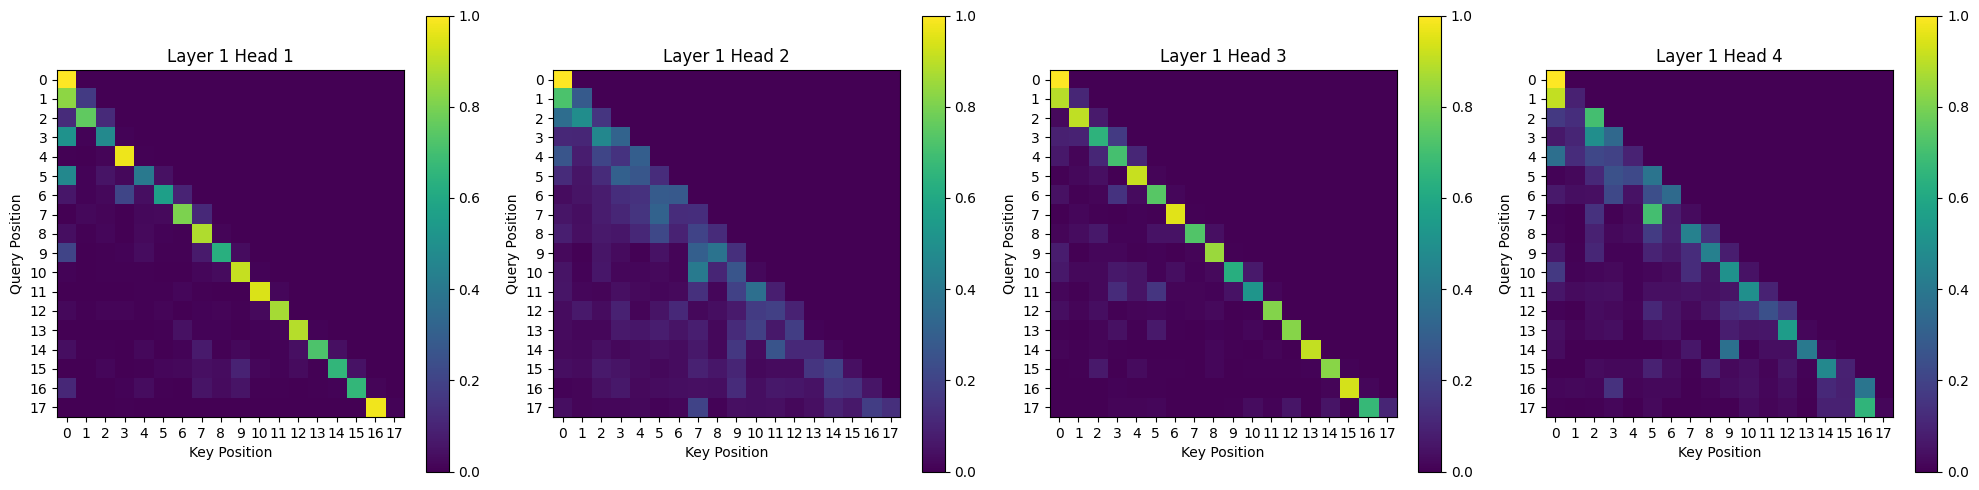

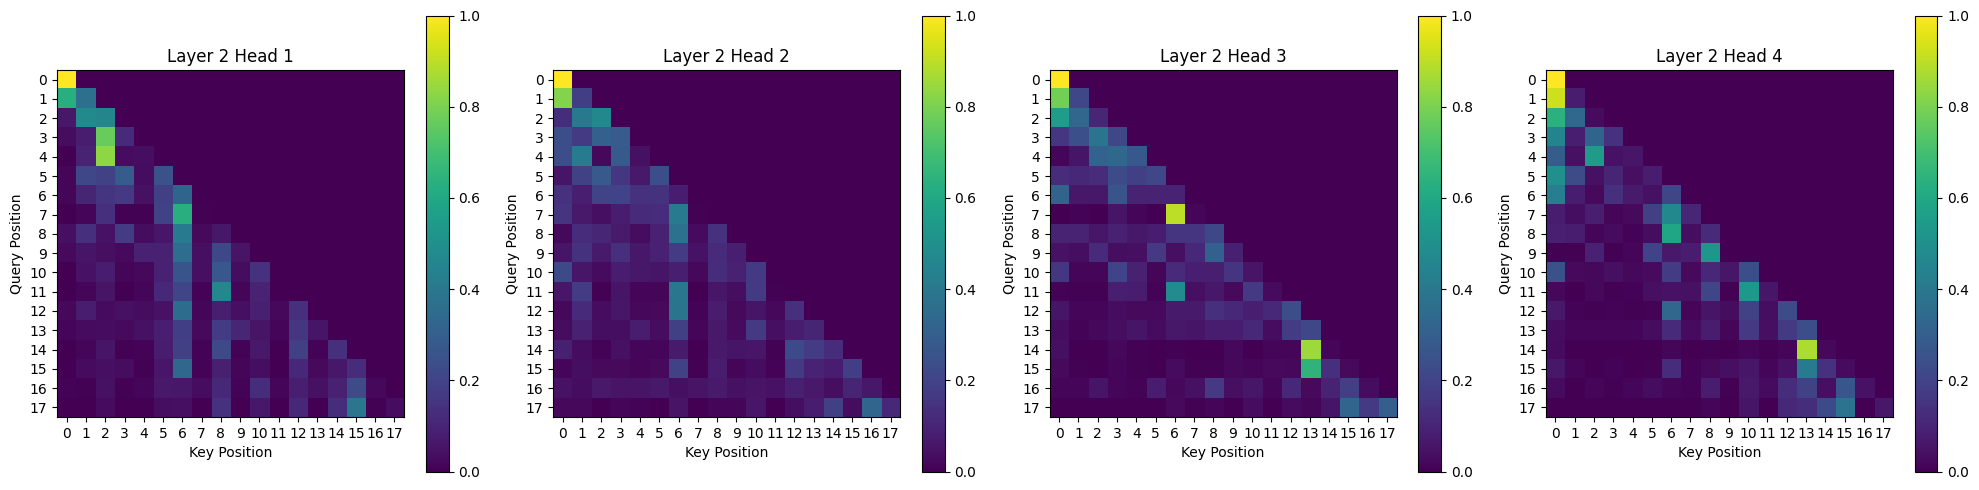

In [43]:
visualize_attention(model_moe, prompt)

# Conclusions

- Los mapas de atención muestran que el modelo aprendió correctamente el patrón autoregresivo: cada posición se concentra principalmente en tokens previos, con diagonales claras y atención decreciente hacia el pasado.

- Las diferencias entre cabezas dentro de una misma capa reflejan que cada una captura relaciones distintas: algunas son más locales (atención muy cerca de la diagonal) mientras que otras muestran saltos intermedios o picos aislados.

- La segunda capa presenta patrones de atención más dispersos que la primera, lo que indica que el modelo aprendió dependencias más globales en niveles superiores de procesamiento.

- La presencia de picos de atención en posiciones específicas sugiere que ciertas cabezas desarrollaron roles funcionales, como rastrear inicios de palabras o repeticiones.

- Las generaciones producidas muestran coherencia básica y continuidad, confirmando que el mecanismo de atención está funcionando y que el modelo internalizó la estructura secuencial del corpus.

- Al comparar generaciones con distintas configuraciones (greedy, temperature, top-k/top-p), se observa cómo la atención influye en la diversidad: métodos deterministas producen textos más repetitivos, mientras que sampling genera salidas más variadas y naturales.

- Aunque los expertos del MoE tienen arquitecturas diferentes, los resultados muestran que el gating distribuye los tokens entre ellos de forma efectiva, contribuyendo a la diversidad de patrones de atención.

- En conjunto, los gráficos y las generaciones evidencian que TinyGPT logra reproducir comportamientos característicos de un transformer real, incluso con una arquitectura reducida.

# Congratulations! 🎉

After completing the tasks you've successfully pretrained for first GPT, remember to add your conclusions and findings! And you can now brag to your friend on how LLMs and GPTs work!

